In [71]:
import numpy as np
import pandas as pd
from scipy import interp

from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.svm import SVC

import matplotlib.pyplot as plt

import pprint
%matplotlib inline

In [4]:
data = load_iris()

In [79]:
X = data['data']
y = data['target']

X, y = X[y != 2], y[y != 2]

n_samples, n_features = X.shape

X.shape

(100, 4)

In [80]:
# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

cv = StratifiedKFold(n_splits=6)
classifier = SVC(kernel='linear', probability=True,
                     random_state=random_state)

## K-Fold Stratified + AUC ROC Plots

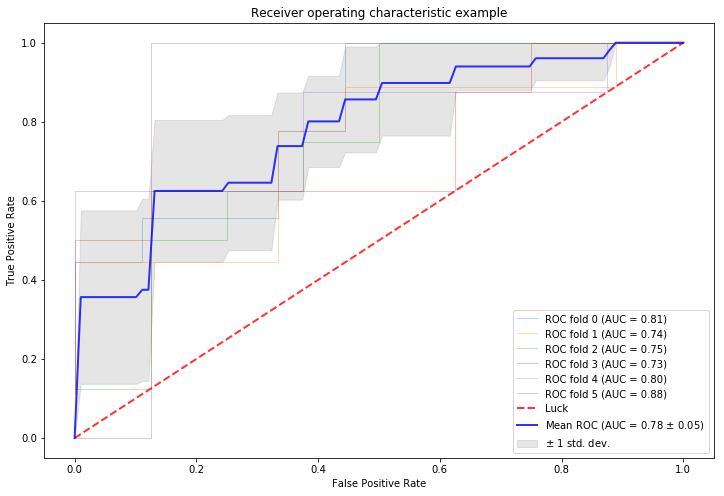

In [81]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(12, 8))

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## F1-score, FPR, FNR

In [82]:
cv = StratifiedKFold(n_splits=5, random_state=42)
scores = []
conf_mat = np.zeros((2, 2))      # Binary classification
false_pos = set()
false_neg = set()

for train_i, val_i in cv.split(X, y):
    X_train, X_val = X[train_i], X[val_i]
    y_train, y_val = y[train_i], y[val_i]

    print("Fitting fold...")
    classifier.fit(X_train, y_train)

    print("Predicting fold...")
    y_pprobs = classifier.predict_proba(X_val)       # Predicted probabilities
    y_plabs = np.squeeze(classifier.predict(X_val))  # Predicted class labels

    scores.append(roc_auc_score(y_val, y_pprobs[:, 1]))
    confusion = confusion_matrix(y_val, y_plabs)
    conf_mat += confusion

    # Collect indices of false positive and negatives
    fp_i = np.where((y_plabs==1) & (y_val==0))[0]
    fn_i = np.where((y_plabs==0) & (y_val==1))[0]
    false_pos.update(val_i[fp_i])
    false_neg.update(val_i[fn_i])

    print("Fold score: ", scores[-1])
    print("Fold CM: \n", confusion)

Fitting fold...
Predicting fold...
Fold score:  0.74
Fold CM: 
 [[5 5]
 [3 7]]
Fitting fold...
Predicting fold...
Fold score:  0.61
Fold CM: 
 [[6 4]
 [5 5]]
Fitting fold...
Predicting fold...
Fold score:  0.96
Fold CM: 
 [[8 2]
 [1 9]]
Fitting fold...
Predicting fold...
Fold score:  0.74
Fold CM: 
 [[4 6]
 [2 8]]
Fitting fold...
Predicting fold...
Fold score:  0.87
Fold CM: 
 [[9 1]
 [3 7]]


In [83]:
def class_report(conf_mat):
    tp, fp, fn, tn = conf_mat.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        # (true negative rate)
    measures['sensitivity'] = tp / (tp + fn)        # (recall, true positive rate)
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures

In [84]:
print("\nMean score: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))
conf_mat /= 5
print("Mean CM: \n", conf_mat)
print("\nMean classification measures: \n")
pprint.pprint(class_report(conf_mat))
scores, conf_mat, {'fp': sorted(false_pos), 'fn': sorted(false_neg)}


Mean score: 0.78 (+/- 0.24)
Mean CM: 
 [[ 6.4  3.6]
 [ 2.8  7.2]]

Mean classification measures: 

{'accuracy': 0.68000000000000005,
 'f1score': 0.66666666666666663,
 'precision': 0.64000000000000001,
 'sensitivity': 0.69565217391304357,
 'specificity': 0.66666666666666663}


([0.73999999999999999,
  0.60999999999999999,
  0.96000000000000008,
  0.73999999999999999,
  0.87],
 array([[ 6.4,  3.6],
        [ 2.8,  7.2]]),
 {'fn': [51, 53, 56, 60, 62, 64, 66, 68, 73, 80, 81, 93, 98, 99],
  'fp': [1, 4, 5, 7, 9, 14, 16, 18, 19, 23, 26, 31, 33, 34, 36, 38, 39, 49]})